In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import sim_template as sim
from importlib import reload 
import TSPN

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [3]:
#If we're feeling it
if False:
    %store -r dt_sys AORP TSPNP tjcps pjcps qBase region pcs pfs pjcps prob_pred_con ccs cfs true_joint_con_fields tjcps

In [14]:
#Setup the communication environment:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 5.2 # per SF data should be in [2, 10]
kPL = -20 # per SF data, [-20, 90]

decorrSH = 2.09    
alpha = 16 # per SF data [4,100]%too high - worse prediction
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
l = 18
l_inner=5
c = np.array([25, 25])

qBase = np.array([c+l_inner*np.array([-(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([-(np.sqrt(3)/2), -1/2]), 
                  c+l_inner*np.array([(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([(np.sqrt(3)/2), -1/2]),
                  [25, 25+l_inner], [25, 25+l_inner+l]])


sub_regions = [[28,4,25,0],
               [46,22, 25, 0],
               [33, 17, 47, 17]]



cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n=3
p_th = 0.5

bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
els = [0.3/beta, 0.01/beta, 0.01/beta]

In [15]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


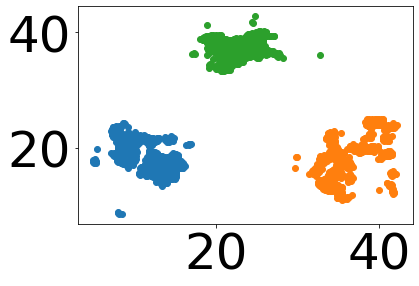

In [16]:
for points in tjcps:
    plt.scatter(points[:,0], points[:,1])

In [19]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)

print(prob_pred_con)

Drawing 600 samples from Channel 1
Completed PredictedChannel 1
Drawing 600 samples from Channel 2
Completed PredictedChannel 2
Drawing 600 samples from Channel 3
Completed PredictedChannel 3
Drawing 600 samples from Channel 4
Completed PredictedChannel 4
Drawing 480 samples from Channel 5
Completed PredictedChannel 5
Drawing 480 samples from Channel 6
Completed PredictedChannel 6
[0.808135593220339, 0.5616197183098591, 0.7716535433070866]


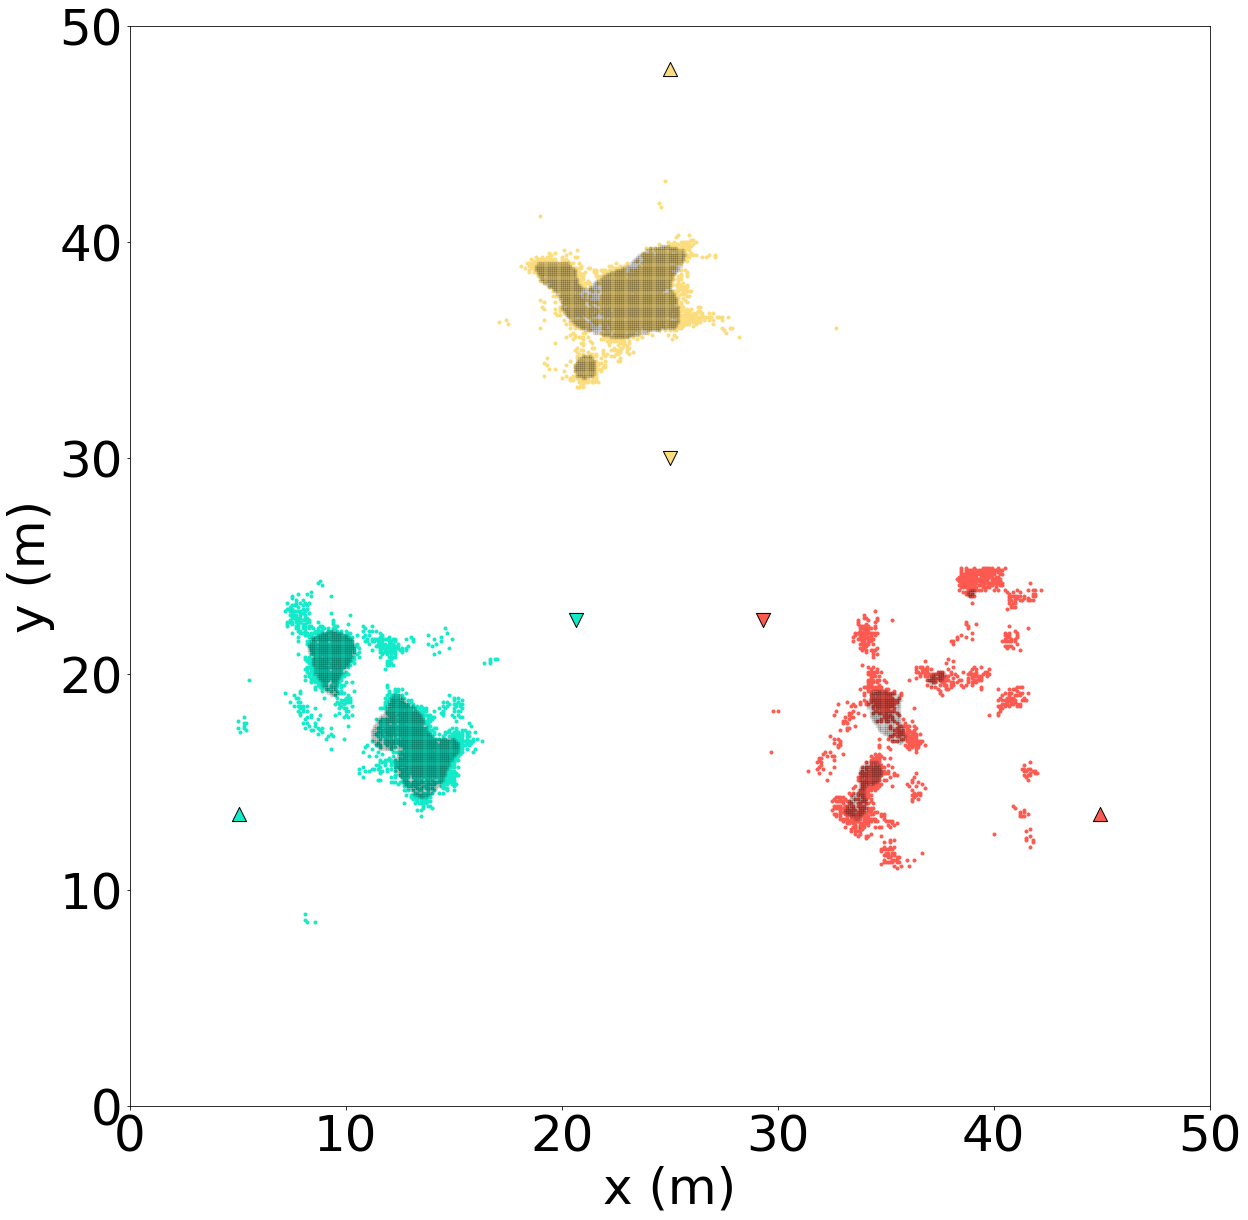

In [20]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [21]:
import cplex_solvers as CPLX
reload(CPLX)
reload(dtr)
reload(TSPN)
reload(sim)
reload(PS)
reload(MRP)

dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps = dt_sys.ps

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
10 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
11 total subregions


Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
11 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 56.85
Elapsed Time: 0.16
Finding AORP
Found AORP
[[0.         0.46589682 0.53410318]
 [0.17367543 0.         0.82632457]
 [0.19416439 0.80583561 0.        ]]
[0.08 0.8  0.8 ]
[0.1009271  0.41887521 0.48019769]
[0.15544001 0.416979   0.42758099]
[18.74812122 19.52144997 19.29859267]
30.688897283072716
30.260862314229314
Finding AORP
Found AORP
[[0.         0.48053394 0.51946606]
 [0.51273347 0.         0.48726653]
 [0.53216764 0.46783236 0.        ]]
[0.8 0.8 0.8]
[0.35342706 0.31070025 0.3358727 ]
[0.34324951 0.32169353 0.33505696]
[18.47917561 19.46305837 18.80767741]
39.17413537446393
31.698371061067792
Finding AORP
Found AORP
[[0.00000000e+00 4.96617627e-01 5.03382373e-01]
 [9.99492936e-01 0.00000000e+00 5.07064351e-04]
 [9.99499746e-01 5.00253534e-04 0.00000000e+00]]


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[[0.         0.32915605 0.67084395]
 [0.05249822 0.         0.94750178]
 [0.10146562 0.89853438 0.        ]]
[0.08 0.8  0.8 ]
[0.03583739 0.31735995 0.64680266]
[0.07203889 0.45167314 0.47628796]
[46.31281734 19.91248618 20.96899437]
45.79154701137973
54.96627931606772
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[[0.         0.45650022 0.54349978]
 [0.29497166 0.         0.70502834]
 [0.33249577 0.66750423 0.        ]]
[0.8 0.8 0.8]
[0.18526364 0.37192732 0.44280903]
[0.23910783 0.37004495 0.39084723]
[41.74843876 26.69834567 26.53045138]
68.77189033924397
57.653177228614105
Finding AORP
Found AORP
[[0.         0.4954448  0.5045552 ]
 [0.71445066 0.         0.28554934]
 [0.71815344 0.28184656 0.        ]]
[8.  0.8 0.8]
[0.5579931  0.21899002 0.22301688]
[0.41735608 0.28942082 0.2932231 ]
[40.36985987 35.78795405 35.44896648]
84.9660300816884
73.77914817890829
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
14 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 152.37
Elapsed Time: 0.16
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[[0.         0.30698587 0.69301413]
 [0.03349857 0.         0.96650143]
 [0.07256558 0.92743442 0.        ]]
[0.08 0.8  0.8 ]
[0.0234562  0.29978515 0.67675865]
[0.05072454 0.46484718 0.48442828]
[70.79391006 20.1548409  21.97671617]
59.66836613472008
81.07013516885164
Finding AORP
Found AORP
[[0.         0.45588633 0.54411367]
 [0.22045618 0.         0.77954382]
 [0.25235427 0.74764573 0.        ]]
[0.8 0.8 0.8]
[0.13335588 0.39509121 0.47155291]
[0.19142153 0.39584493 0.41273354]
[66.2745371  30.38289632 31.01894705]
97.58528883034327
85.07714335046337
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[[0.         0.49570528 0.50429472]
 [0.58613657 0.         0.41386343]
 [0.59029767 0.40970233 0.        ]]
[8.  0.8 0.8]
[0.41664105 0.28917411 0.29418484]
[0.37036733 0.31322571 0.31640696]
[64.69117384 47.87408009 47.68294127]
128.25748493961976
109.05142039483943
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
11 total subregions
 &  0.08 & 18.75 & 0.16 &  0.80 & 19.52 & 0.42 &  0.80 & 19.30 & 0.43 & 30.69 & 30.26\\ 
 \hline 
 &  0.80 & 18.48 & 0.34 &  0.80 & 19.46 & 0.32 &  0.80 & 18.81 & 0.34 & 39.17 & 31.70\\ 
 \hline 
 &  8.00 & 18.02 & 0.50 &  0.80 & 18.17 & 0.25 &  0.80 & 17.87 & 0.25 & 40.59 & 40.40\\ 
 \hline 
 &  0.08 & 46.31 & 0.07 &  0.80 & 19.91 & 0.45 &  0.80 & 20.97 & 0.48 & 45.79 & 54.97\\ 
 \hline 
 &  0.80 & 41.75 & 0.24 &  0.80 & 26.70 & 0.37 &  0.80 & 26.53 & 0.39 & 68.77 & 57.65\\ 
 \hline 
 &  8.00 & 40.37 & 0.42 &  0.80 & 35.79 & 0.29 &  0.80 & 35.45 & 0.29 & 84.97 & 73.78\\ 
 \hline 
 &  0.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


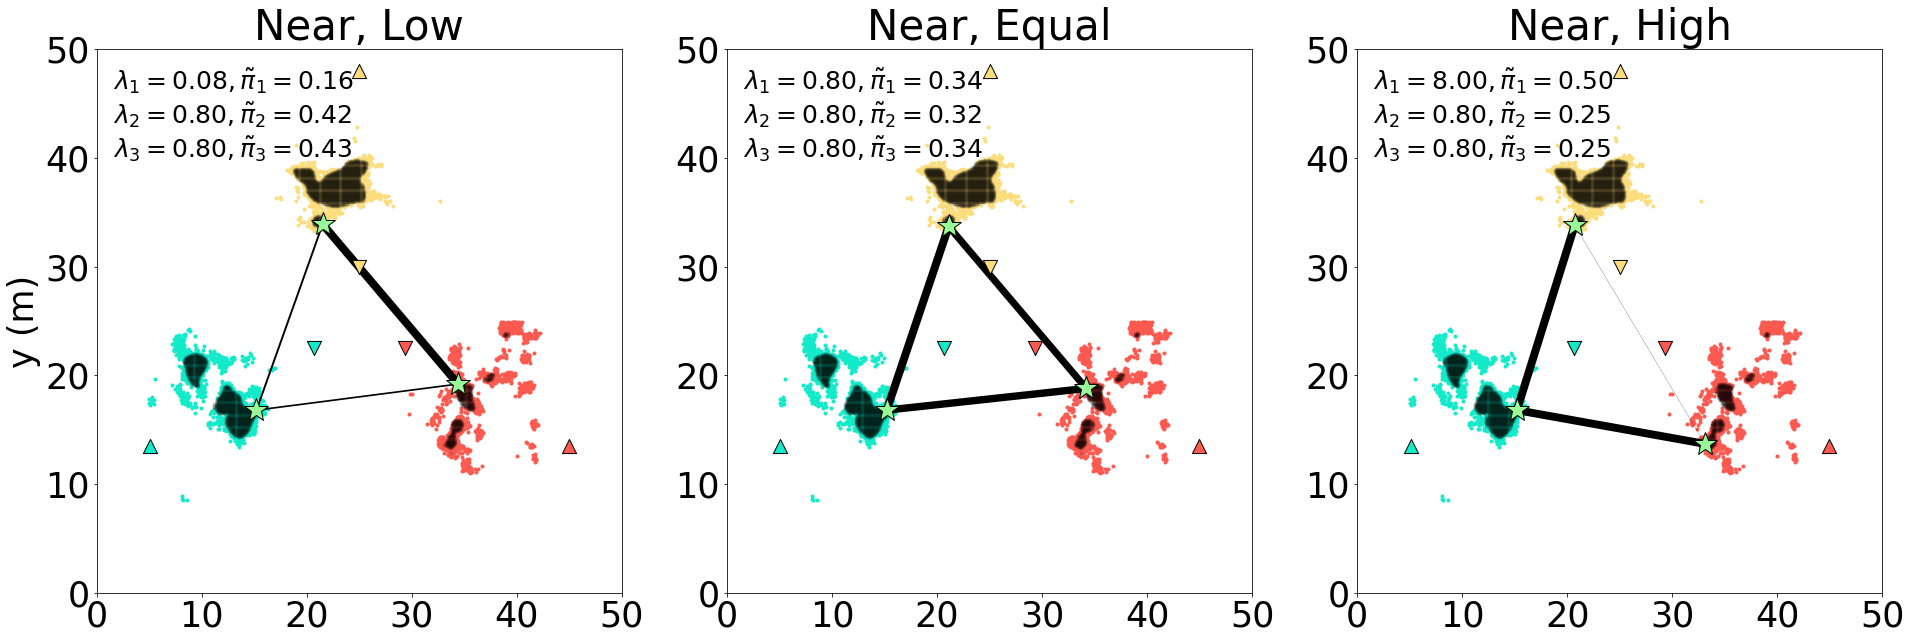

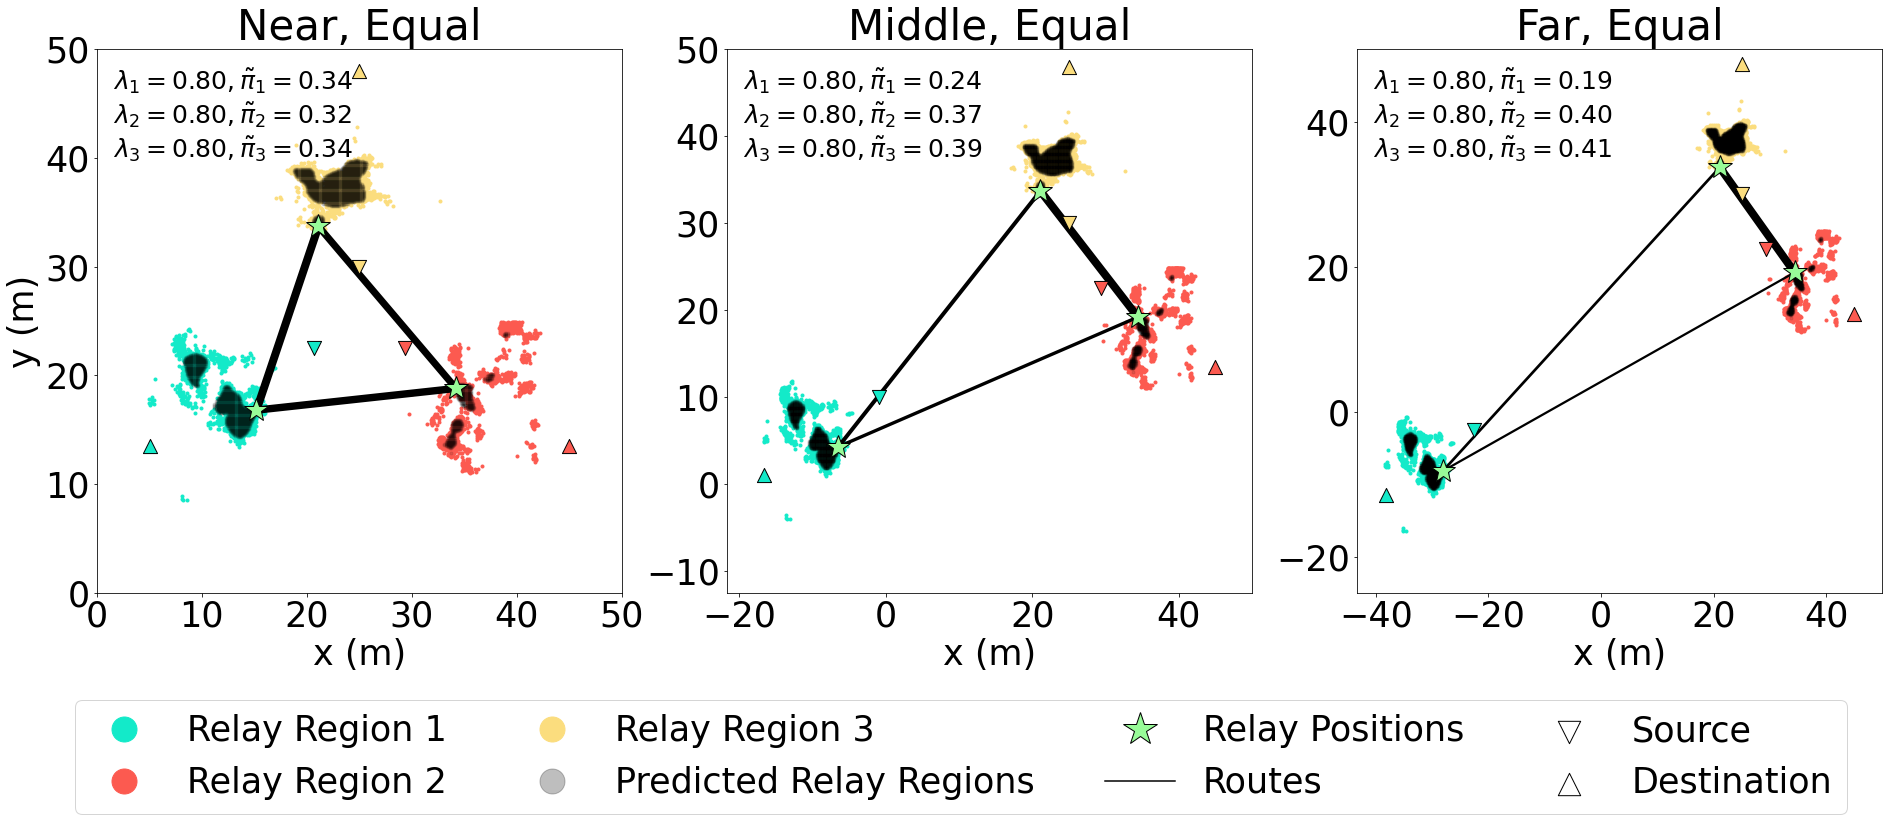

In [22]:


reload(CPLX)
reload(dtr)
reload(TSPN)
reload(sim)
reload(PS)
#reload(MRP)
v = 1
# dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
# ps = dt_sys.ps

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

els = np.array([0.05, 0.05, 0.05])/beta
vals = np.array([0.005, 0.05, 0.5])/beta
Ws = []
W_cys = []
n_steps = 3
l = np.reshape(np.array([0,25,50]),(n_steps,1))
offsets = -1*l*np.array([np.cos(np.pi/6), np.sin(np.pi/6)])
regions = np.reshape(np.array([x_max, x_min, y_max, y_min]), (4,1)) + np.array([np.zeros(n_steps), offsets[:,0], np.zeros(n_steps), offsets[:,1]])
regions = regions.T


latex_table_str = ''

#figA, (axA1, axA2, axA3) = plt.subplots(1,3, figsize=(32, 16))
figA, axsA = plt.subplots(1,3, figsize=(32, 10))
figB, axsB = plt.subplots(1,3, figsize=(32, 10))
positions = ["Near", "Middle", "Far"]
rates = ['Low', "Equal", "High"]
k = 0
for offset, tregion in zip(offsets, regions):
    dt_sys.shiftRegion(0, offset)
    dt_sys.region = tregion
    tjcps[0] += offset
    pjcps[0] += offset
    qBase[0] += offset
    qBase[1] += offset
    #find the TSPNP
    sys_regions = dt_sys.cregions
    tspn_min, tspn_argmin = TSPN.TSPN_BF(sys_regions)
    TSPNP={'X':tspn_argmin[0], 'SEQ':tspn_argmin[1]}
    S_cy = dtr.XtoS(TSPNP['X'])
    S_cyv = np.zeros(n)
    seq = TSPNP['SEQ']
    for i in range(n):
        S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]
    
    for j in range(len(vals)):
        val = vals[j]
        els[0] =  val
        ps.Ls = els
        print("Finding AORP")
        AORP = sim.calc_AORP(dt_sys, v)
        print("Found AORP")
        pi = AORP['pi']
        S = dtr.XtoS(AORP['X'])
        
        
        #S_i = S @ pi
        W_rnd = ps._calc_avg_wait_random(S, pi)
        W_cy = ps._calc_avg_wait_cyclic(S_cyv)
        Ws.append(W_rnd)
        W_cys.append(W_cy)
         
        #print(S)
        P_tilde, pi_tilde = sim.pi_to_P(pi)
        print(P_tilde)
        S_i = np.diag(P_tilde@S)
        print(els)
        print(pi)
        print(pi_tilde)
        print(S_i)
        print(W_rnd)
        print(W_cy)
        #plot across varying arrival rates when regions are ~ equidistant
        if k == 0:
            ax = axsA[j]
            sim.plot_relay_regions(n, tjcps, pjcps, els = None, pi = None, ax = ax)
            sim.plot_bs(qBase, ax)
            sim.set_lims(tregion, ax)
            sim.plot_AORP_routes(AORP, ax)
            ax.invert_yaxis()
            if j == 0:
                ax.set_ylabel('y (m)')
            ax.set_title(positions[k]+', '+rates[j])
            
            label1 = '$\\lambda_%d = %.2f, \\tilde{\\pi}_%d = %.2f$'%(1, els[0], 1, pi_tilde[0])
            label2 = '$\\lambda_%d = %.2f, \\tilde{\\pi}_%d = %.2f$'%(2,  els[1], 2, pi_tilde[1])
            label3 = '$\\lambda_%d = %.2f, \\tilde{\\pi}_%d = %.2f$'%(3, els[2], 3,pi_tilde[2] )
            label = label1 +"\n" + label2 + "\n" + label3
            ax.annotate(label, xy=(0.03,0.8),xycoords='axes fraction',
             fontsize=25)
        #plot across varying distances when arrival rates are ~ equidistant
        if j == 1:
            ax = axsB[k]
            sim.plot_relay_regions(n, tjcps, pjcps, els = None, pi = None, ax = ax)
            sim.plot_bs(qBase, ax)
            sim.set_lims(tregion, ax)
            sim.plot_AORP_routes(AORP, ax)
            ax.invert_yaxis()
            if k == 0:
                ax.set_ylabel('y (m)')
            ax.set_xlabel('x (m)')
            ax.set_title(positions[k]+', '+rates[j])
            label1 = '$\\lambda_%d = %.2f, \\tilde{\\pi}_%d = %.2f$'%(1, els[0], 1, pi_tilde[0])
            label2 = '$\\lambda_%d = %.2f, \\tilde{\\pi}_%d = %.2f$'%(2,  els[1], 2, pi_tilde[1])
            label3 = '$\\lambda_%d = %.2f, \\tilde{\\pi}_%d = %.2f$'%(3, els[2], 3,pi_tilde[2] )
            label = label1 +"\n" + label2 + "\n" + label3
            ax.annotate(label, xy=(0.03,0.8),xycoords='axes fraction',
             fontsize=25)
        
        latex_table_str += ' & '
        for i in range(n):   
            latex_table_str += " %.2f & %.2f & %.2f & "%(els[i], S_i[i], pi_tilde[i])
        latex_table_str += "%.2f & %.2f\\\\ \n \\hline \n"%(W_rnd, W_cy)
    dt_sys.shiftRegion(0, -offset)#move back
    tjcps[0] -= offset
    pjcps[0] -= offset
    qBase[0] -= offset
    qBase[1] -= offset
    k += 1
print(latex_table_str)

handles, labels = axsB[2].get_legend_handles_labels()
figB.legend(handles, labels, loc='upper center', bbox_to_anchor=[0.5,0.00], ncol=4)

figA.savefig('fig3_variation_over_lambda.eps', format='eps', bbox_inches='tight')
figB.savefig('fig3_variation_over_position.eps', format='eps', bbox_inches='tight')
figA.savefig('fig3_variation_over_lambda.png', format='png', bbox_inches='tight')
figB.savefig('fig3_variation_over_position.png', format='png', bbox_inches='tight')

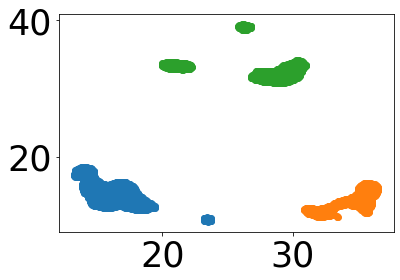

In [11]:
for Xi in dt_sys.Xis:
    pts = Xi['points']
    plt.scatter(pts[:,0], pts[:,1])

In [87]:
#plot vs offset
import cplex_solvers as CPLX

reload(CPLX)
reload(dtr)
reload(TSPN)
reload(sim)
reload(PS)
#reload(MRP)
v = 1

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

base = 0.05/beta
els = base*np.ones(3)
Ws = []
W_cys = []
n_steps = 11
l = np.reshape(np.linspace(0,50,n_steps),(n_steps,1))
offsets = -1*l*np.array([np.cos(np.pi/6), np.sin(np.pi/6)])
regions = np.reshape(np.array([x_max, x_min, y_max, y_min]), (4,1)) + np.array([np.zeros(n_steps), offsets[:,0], np.zeros(n_steps), offsets[:,1]])
regions = regions.T

n_vals = 15
scale = np.linspace(0.5, 2, n_vals)
dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps = dt_sys.ps

pi1s = np.zeros((n_steps, n_vals))
pis = np.zeros((n_steps, n_vals, 3))

# for offset, tregion in zip(offsets, regions):
for i in range(n_steps):
    offset = offsets[i]
    tregion = regions[i]
    dt_sys.shiftRegion(0, offset)
    dt_sys.region = tregion

    for j in range(n_vals):
        print("Iteration %d, %d"%(i,j))
        c = scale[j]
        els[0] =  c*base
        ps.Ls = els

        AORP = sim.calc_AORP(dt_sys, v)
        pi = AORP['pi']
        pis[i,j] = pi
        S = dtr.XtoS(AORP['X'])
        #normalize
        #get observed
        P, pi_obs = sim.pi_to_P(pi)
        #pi1s[i,j] = pi_obs[0]
        pi1s[i,j] = pi[0]
        print(pi_obs[0])
        
        if j>0:
            if pi1s[i,j]<pi1s[i, j-1]:#just try to smooth once
                print(els)
                print(beta)
                print(S)
                print("oops, lets try that again!")
                AORP = sim.calc_AORP(dt_sys, v)
                pi = AORP['pi']
                pis[i,j] = pi
                S = dtr.XtoS(AORP['X'])
                #normalize
                #get observed
                P, pi_obs = sim.pi_to_P(pi)
                #pi1s[i,j] = pi_obs[0]
                pi1s[i,j] = pi[0]
                print(pi_obs[0])
                
            if pi1s[i,j]<pi1s[i, j-1]:
                print("weird spike detected")
                print("params", offset, c)
                print("Previous pi", pis[i, j-1])
                print("Current pi", pis[i, j])
                print("pi[0] should increase")
                #seems to be only an issues with varying scale
                #dig in deeper
                W_rnd = ps._calc_avg_wait_random(S, pi)
                print("current wait time: ", W_rnd)
                pi_test = pis[i,j-1]
                for k in range(10):
                    
                    if pi_test[0]<1:
                        W_rnd = ps._calc_avg_wait_random(S, pi_test)
                        print("Wait time using previous frequencies: ", W_rnd, pi_test)
                    pi_test[0] += 0.02
                    pi_test[1] -= 0.01
                    pi_test[1] -= 0.01
#                 fig = plt.figure(figsize=(12,12))
#                 for k in np.linspace(scale[j-1], scale[j], 10):
#                     els[0] =  k*base
#                     ps.Ls = els

#                     AORP = sim.calc_AORP(dt_sys, v)
#                     pi = AORP['pi']
#                     pis[i,j] = pi
#                     S = dtr.XtoS(AORP['X'])
#                     #normalize
#                     #get observed
#                     P, pi_obs = sim.pi_to_P(pi)
#                     print("scale: ", k, pi_obs[0])
#                     X = AORP['X']
#                     plt.plot(X[:,0], X[:,1], '*', label="Scale %.2f"%(k))
                
#                 plt.legend()
#                 plt.show()

    dt_sys.shiftRegion(0, -offset)#move back

Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
18 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
12 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
10 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
18 total subregions
Iteration 0, 0
0.06346924924248751
Iteration 0, 1
0.07282329870555376
Iteration 0, 2
0.08151109060089794
Iteration 0, 3
0.08957005692651382
Iteration 0, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.09703433878749886
Iteration 0, 5
0.10398310943917548
Iteration 0, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.11091498363138841
Iteration 0, 7
0.15833648776214737
Iteration 0, 8
0.17439917726580398
Iteration 0, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.16303982819761448
[1.17142857 0.8        0.8       ]
0.0625
[[  0.         121.90679291 117.36166182]
 [121.90679291   0.          13.62093993]
 [117.36166182  13.62093993   0.        ]]
oops, lets try that again!


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.17120707010198147
weird spike detected
params [-0. -0.] 1.4642857142857142
Previous pi [0.11803604 0.43072183 0.45124213]
Current pi [0.1151676  0.44802968 0.43680272]
pi[0] should increase
current wait time:  159.93030747164264
Wait time using previous frequencies:  160.07653229447098 [0.11803604 0.43072183 0.45124213]
Wait time using previous frequencies:  162.10977818627214 [0.13803604 0.41072183 0.45124213]
Wait time using previous frequencies:  164.62856971266424 [0.15803604 0.39072183 0.45124213]
Wait time using previous frequencies:  167.5024550029682 [0.17803604 0.37072183 0.45124213]
Wait time using previous frequencies:  170.68490270903078 [0.19803604 0.35072183 0.45124213]
Wait time using previous frequencies:  174.17787254786475 [0.21803604 0.33072183 0.45124213]
Wait time using previous frequencies:  178.01776941725583 [0.23803604 0.31072183 0.45124213]
Wait time using previous frequencies:  182.27157371609064 [0.25803604 0.29072183 0.45124213]
Wait time using previous f

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.07083342978369757
Iteration 1, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.07938182341804485
Iteration 1, 3
0.08732073623479172
Iteration 1, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.09470505122532065
Iteration 1, 5
0.10157256959442296
Iteration 1, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.15578544732644206
Iteration 1, 7
0.15247507581340003
[1.  0.8 0.8]
0.0625
[[  0.         126.90678838 122.33476857]
 [126.90678838   0.          13.62094009]
 [122.33476857  13.62094009   0.        ]]
oops, lets try that again!
0.1581148702023029
Iteration 1, 8
0.16275698909132527
Iteration 1, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.16327488954434327
Iteration 1, 10
0.14287335005117938
[1.25714286 0.8        0.8       ]
0.0625
[[  0.         126.90678838 122.33476748]
 [126.90678838   0.          13.6209405 ]
 [122.33476748  13.6209405    0.        ]]
oops, lets try that again!
0.14287334335729815
weird spike detected
params [-4.33012702 -2.5       ] 1.5714285714285714
Previous pi [0.10775594 0.41884725 0.47339681]
Current pi [0.0900606  0.40853979 0.50139962]
pi[0] should increase
current wait time:  165.85084857249637
Wait time using previous frequencies:  166.45023287207295 [0.10775594 0.41884725 0.47339681]
Wait time using previous frequencies:  168.15286248306626 [0.12775594 0.39884725 0.47339681]
Wait time using previous frequencies:  170.5521049303657 [0.14775594 0.37884725 0.47339681]
Wait time using previous frequencies:  173.44036657670625 [0.16775594 0.35884725 0.47339681]
Wait time using previous frequencies:  176.73815150477563 [0.18775594 0.33884725 0.47339681]
Wait time using previous frequencies:

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.05990623471242369
Iteration 2, 1


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.06894815317657221
Iteration 2, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.07738030225379183
Iteration 2, 3
0.08521071964936992
Iteration 2, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.09250703453887027
Iteration 2, 5
0.09930219856701472
Iteration 2, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.10563574682865243
Iteration 2, 7
0.15485103920112947
Iteration 2, 8
0.1656673875314176
Iteration 2, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.1690445839712644
Iteration 2, 10
0.1504531453424944
[1.25714286 0.8        0.8       ]
0.0625
[[  0.         131.90678355 127.30998205]
 [131.90678355   0.          13.62094004]
 [127.30998205  13.62094004   0.        ]]
oops, lets try that again!
0.17391514165816038
Iteration 2, 11
0.1448382466378129
[1.34285714 0.8        0.8       ]
0.0625
[[  0.         131.90678311 127.30998213]
 [131.90678311   0.          13.6209398 ]
 [127.30998213  13.6209398    0.        ]]
oops, lets try that again!
0.1448382371466436
weird spike detected
params [-8.66025404 -5.        ] 1.6785714285714286
Previous pi [0.1176083  0.44992902 0.43246268]
Current pi [0.09169647 0.4092016  0.49910194]
pi[0] should increase
current wait time:  173.1367534019972
Wait time using previous frequencies:  174.4671023872394 [0.1176083  0.44992902 0.43246268]
Wait time using previous frequencies:  176.29984200423453 [0.1376083  0.42992902 0.43246268]
Wait time using previous frequencies:  178.63938284537264 [0.1576083 

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.06716944692130362
Iteration 3, 2
0.0754730185507608
Iteration 3, 3
0.08321152755657735
Iteration 3, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.09042795431933189
Iteration 3, 5
0.09713642113174864
Iteration 3, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.10341790945251925
Iteration 3, 7
0.14299627461704803
Iteration 3, 8
0.11523873398856638
[1.08571429 0.8        0.8       ]
0.0625
[[  0.         137.52673606 140.56908266]
 [137.52673606   0.          11.69252098]
 [140.56908266  11.69252098   0.        ]]
oops, lets try that again!
0.11523873398856638
weird spike detected
params [-12.99038106  -7.5       ] 1.3571428571428572
Previous pi [0.08953904 0.39433799 0.51612296]
Current pi [0.06920759 0.50430531 0.4264871 ]
pi[0] should increase
current wait time:  176.4224598323388
Wait time using previous frequencies:  178.374352049691 [0.08953904 0.39433799 0.51612296]
Wait time using previous frequencies:  181.4120931838136 [0.10953904 0.37433799 0.51612296]
Wait time using previous frequencies:  185.26839384079844 [0.12953904 0.35433799 0.51612296]
Wait time using previous frequencies:  189.7141864316185 [0.14953904 0.33433799 0.51612296]
Wait time using previous frequencies:  194.69583883027914 [0.16953904 0.31433799 0.51612296]
Wait 

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.12017368574711365
Iteration 3, 10
0.17348650443611477
Iteration 3, 11
0.12984105523276063
[1.34285714 0.8        0.8       ]
0.0625
[[  0.         137.22987036 140.56908265]
 [137.22987036   0.          11.74436035]
 [140.56908265  11.74436035   0.        ]]
oops, lets try that again!
0.17014396953831198
weird spike detected
params [-12.99038106  -7.5       ] 1.6785714285714286
Previous pi [0.11723618 0.44764477 0.43511906]
Current pi [0.11356145 0.40737451 0.47906405]
pi[0] should increase
current wait time:  180.15277055068356
Wait time using previous frequencies:  180.57468428213815 [0.11723618 0.44764477 0.43511906]
Wait time using previous frequencies:  182.57361347565148 [0.13723618 0.42764477 0.43511906]
Wait time using previous frequencies:  185.07959006718528 [0.15723618 0.40764477 0.43511906]
Wait time using previous frequencies:  187.94234139325854 [0.17723618 0.38764477 0.43511906]
Wait time using previous frequencies:  191.1011812345796 [0.19723618 0.36764477 0.43511906]

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.05674149435703968
Iteration 4, 1


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.06549102685125924
Iteration 4, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.07367554050556199
Iteration 4, 3
0.0813196069521534
Iteration 4, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.0884495996927346
Iteration 4, 5
0.09509358562514693
Iteration 4, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.1013108401419972
Iteration 4, 7
0.15125450354761294
Iteration 4, 8
0.11301529215603862
[1.08571429 0.8        0.8       ]
0.0625
[[  0.         142.57685523 145.55326481]
 [142.57685523   0.          11.68449333]
 [145.55326481  11.68449333   0.        ]]
oops, lets try that again!
0.15537153387863514
Iteration 4, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.1180750115353562
[1.17142857 0.8        0.8       ]
0.0625
[[  0.         142.47381552 145.55326475]
 [142.47381552   0.          11.70122534]
 [145.55326475  11.70122534   0.        ]]
oops, lets try that again!


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.15676056738646332
Iteration 4, 10
0.16534892124098363
Iteration 4, 11
0.1534475278046989
[1.34285714 0.8        0.8       ]
0.0625
[[  0.         141.90677492 137.26581249]
 [141.90677492   0.          13.62093994]
 [137.26581249  13.62093994   0.        ]]
oops, lets try that again!
0.16959286147171032
Iteration 4, 12
0.1440105438405371
[1.42857143 0.8        0.8       ]
0.0625
[[  0.         141.90677487 137.26581268]
 [141.90677487   0.          13.62093989]
 [137.26581268  13.62093989   0.        ]]
oops, lets try that again!
0.1440105431148267
weird spike detected
params [-17.32050808 -10.        ] 1.7857142857142856
Previous pi [0.11365192 0.43104028 0.45530779]
Current pi [0.09108586 0.41111081 0.49780333]
pi[0] should increase
current wait time:  186.33349811414877
Wait time using previous frequencies:  187.32155693797986 [0.11365192 0.43104028 0.45530779]
Wait time using previous frequencies:  189.21064635702243 [0.13365192 0.41104028 0.45530779]
Wait time using previous fre

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.05529030205673065
Iteration 5, 1


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.06389823534506732
Iteration 5, 2
0.07197134430742369
Iteration 5, 3
0.07952080709177711
Iteration 5, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.08657152289837465
Iteration 5, 5
0.09316033575072186
Iteration 5, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.09931006198588882
Iteration 5, 7
0.10507035480211384
Iteration 5, 8
0.1563889961724557
Iteration 5, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.11567195962994227
[1.17142857 0.8        0.8       ]
0.0625
[[  0.         147.53915104 150.53849596]
 [147.53915104   0.          11.69051282]
 [150.53849596  11.69051282   0.        ]]
oops, lets try that again!


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.14749128618910978
weird spike detected
params [-21.65063509 -12.5       ] 1.4642857142857142
Previous pi [0.10215817 0.447273   0.45056883]
Current pi [0.09433432 0.42343129 0.48223439]
pi[0] should increase
current wait time:  188.21737154352675
Wait time using previous frequencies:  189.00071482780632 [0.10215817 0.447273   0.45056883]
Wait time using previous frequencies:  191.41209817259548 [0.12215817 0.427273   0.45056883]
Wait time using previous frequencies:  194.45051008748555 [0.14215817 0.407273   0.45056883]
Wait time using previous frequencies:  197.90202841286654 [0.16215817 0.387273   0.45056883]
Wait time using previous frequencies:  201.68517608075518 [0.18215817 0.367273   0.45056883]
Wait time using previous frequencies:  205.78601733580822 [0.20215817 0.347273   0.45056883]
Wait time using previous frequencies:  210.23295593038125 [0.22215817 0.327273   0.45056883]
Wait time using previous frequencies:  215.0879426897466 [0.24215817 0.307273   0.45056883]
Wait tim

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.05391139619512615
Iteration 6, 1


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.062389292982774444
Iteration 6, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.07035828135089307
Iteration 6, 3
0.07781188790747391
Iteration 6, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.08478914600159783
Iteration 6, 5
0.09130588052828904
Iteration 6, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.09740645993626267
Iteration 6, 7
0.10311120857338359
Iteration 6, 8
0.15286013481618901
Iteration 6, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.1527873755759213
Iteration 6, 10
0.15816558824469779
Iteration 6, 11
0.17071530484096692
Iteration 6, 12
0.12733904856432113
[1.42857143 0.8        0.8       ]
0.0625
[[  0.         152.27840299 155.52467534]
 [152.27840299   0.          11.7353858 ]
 [155.52467534  11.7353858    0.        ]]
oops, lets try that again!
0.1709684037380839
Iteration 6, 13
0.14330852798757224
[1.51428571 0.8        0.8       ]
0.0625
[[  0.         151.90676823 147.22762855]
 [151.90676823   0.          13.62094071]
 [147.22762855  13.62094071   0.        ]]
oops, lets try that again!
0.14330852740969716
weird spike detected
params [-25.98076211 -15.        ] 1.8928571428571428
Previous pi [0.11496785 0.4418783  0.44315385]
Current pi [0.09057003 0.4128103  0.49661967]
pi[0] should increase
current wait time:  199.5654846576403
Wait time using previous frequencies:  200.8008515327129 [0.11496785 0.4418783  0.44315385]
Wait time using previous frequencies:  202.79243551410056 [0.13496785 0.4218783  0.443

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.05260711733812401
Iteration 7, 1


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.06095413981296221
Iteration 7, 2
0.06881216415099395
Iteration 7, 3


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.0761852110410129
Iteration 7, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.08308580023948012
Iteration 7, 5
0.08953847720270923
Iteration 7, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.0955865226905357
Iteration 7, 7
0.10125585460880868
Iteration 7, 8
0.10655432903361879
Iteration 7, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.11158073251377955
Iteration 7, 10
0.11638328819068004
Iteration 7, 11
0.12092183441239976
Iteration 7, 12
0.1252226066084867
Iteration 7, 13
0.16435423906670923
Iteration 7, 14
0.14493014750152325
[1.6 0.8 0.8]
0.0625
[[  0.         156.90676449 152.21041665]
 [156.90676449   0.          13.62093998]
 [152.21041665  13.62093998   0.        ]]
oops, lets try that again!
0.13309064822721398
weird spike detected
params [-30.31088913 -17.5       ] 2.0
Previous pi [0.10854843 0.41323389 0.47821768]
Current pi [0.08278991 0.48984705 0.42736305]
pi[0] should increase
current wait time:  209.07421494724247
Wait time using previous frequencies:  210.85626919760873 [0.10854843 0.41323389 0.47821768]
Wait time using previous frequencies:  213.430989880023 [0.12854843 0.39323389 0.47821768]
Wait time using previous frequencies:  216.69043325428262 [0.14854843 0.37323389 0.47821768]
Wait time using previous frequencies:  220.47306091833178 [0.16854843 0.35323389 0.47821768]
Wait time using previo

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.05136269865635979
Iteration 8, 1


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.05958986504696224
Iteration 8, 2
0.0673454640066187
Iteration 8, 3


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.0746336697647335
Iteration 8, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.08146302501573716
Iteration 8, 5
0.08785747250273851
Iteration 8, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.093847440089357
Iteration 8, 7
0.09946419191272775
Iteration 8, 8
0.10472842025937981
Iteration 8, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.11012032977153778
Iteration 8, 10
0.11445019678111092
Iteration 8, 11
0.1665675729506927
Iteration 8, 12
0.12337185910132982
[1.42857143 0.8        0.8       ]
0.0625
[[  0.         162.3718536  165.49953594]
 [162.3718536    0.          11.7186538 ]
 [165.49953594  11.7186538    0.        ]]
oops, lets try that again!
0.1705854476110682
Iteration 8, 13
0.16629419385036703
[1.51428571 0.8        0.8       ]
0.0625
[[  0.         161.90676231 157.19429276]
 [161.90676231   0.          13.62094164]
 [157.19429276  13.62094164   0.        ]]
oops, lets try that again!
0.17168129138000107
Iteration 8, 14
0.17039989770967504
[1.6 0.8 0.8]
0.0625
[[  0.        161.9067613 157.1942949]
 [161.9067613   0.         13.6209405]
 [157.1942949  13.6209405   0.       ]]
oops, lets try that again!
0.18002548295652354
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
17 total subregions
Extracted edges...
Polygons constructed, looking for holes.

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.05018488496758888
Iteration 9, 1


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.058289432813862604
Iteration 9, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.06594585582879314
Iteration 9, 3


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.07315787243969166
Iteration 9, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.07991348677936419
Iteration 9, 5
0.08624878034656447
Iteration 9, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.09218868907494092
Iteration 9, 7
0.09775648676322948
Iteration 9, 8
0.1029836504906175
Iteration 9, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.10789773361205954
Iteration 9, 10
0.11258237831700746
Iteration 9, 11
0.11735073938642802
Iteration 9, 12
0.15006534739179306
Iteration 9, 13
0.16725760210661755
Iteration 9, 14
0.17430950837516143
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
17 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
18 total subregions
Iteration 10, 0


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.04905671197110388
Iteration 10, 1


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.05704849876979324
Iteration 10, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.06461060154789997
Iteration 10, 3


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.07173554675617506
Iteration 10, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.07842945510128724
Iteration 10, 5
0.08470782360152797
Iteration 10, 6


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.09059551228516428
Iteration 10, 7
0.09612205496995965
Iteration 10, 8
0.10131456385879364
Iteration 10, 9


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.10618788803728837
Iteration 10, 10
0.11121789153397776
Iteration 10, 11
0.15401945967583008
Iteration 10, 12
0.1665627680122695
Iteration 10, 13
0.16537057484039494
[1.51428571 0.8        0.8       ]
0.0625
[[  0.         171.90675538 167.16494474]
 [171.90675538   0.          13.62093976]
 [167.16494474  13.62093976   0.        ]]
oops, lets try that again!
0.1685073605233431
Iteration 10, 14
0.12721096678539406
[1.6 0.8 0.8]
0.0625
[[  0.         172.29552784 175.47725824]
 [172.29552784   0.          11.73226548]
 [175.47725824  11.73226548   0.        ]]
oops, lets try that again!
0.12721096678539406
weird spike detected
params [-43.30127019 -25.        ] 2.0
Previous pi [0.11261577 0.46014349 0.42724074]
Current pi [0.07831004 0.49022569 0.43146426]
pi[0] should increase
current wait time:  226.97861583750557
Wait time using previous frequencies:  229.62836248627352 [0.11261577 0.46014349 0.42724074]
Wait time using previous frequencies:  232.50721539012318 [0.13261577 0.4401434

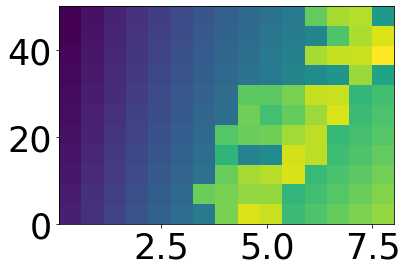

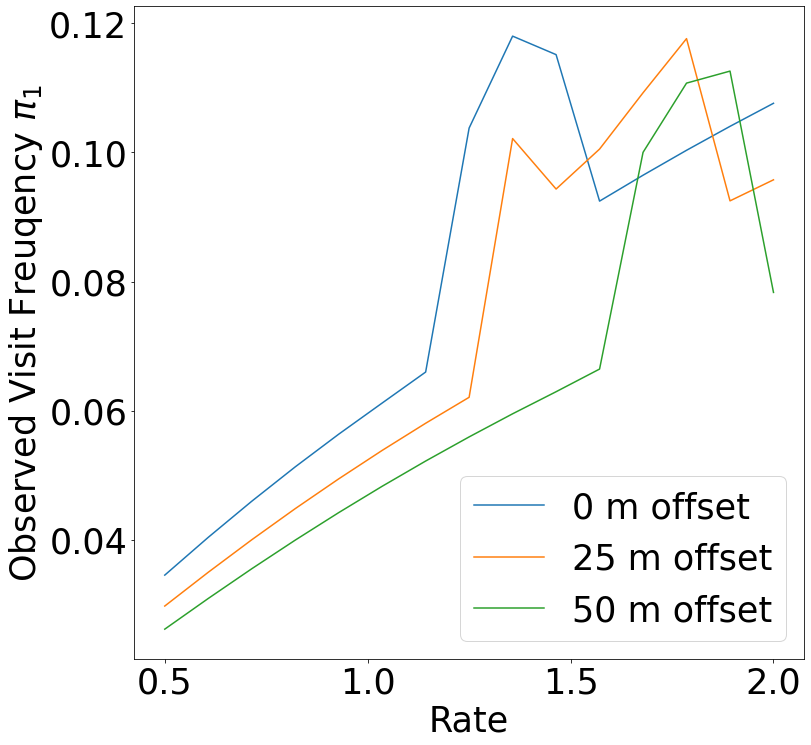

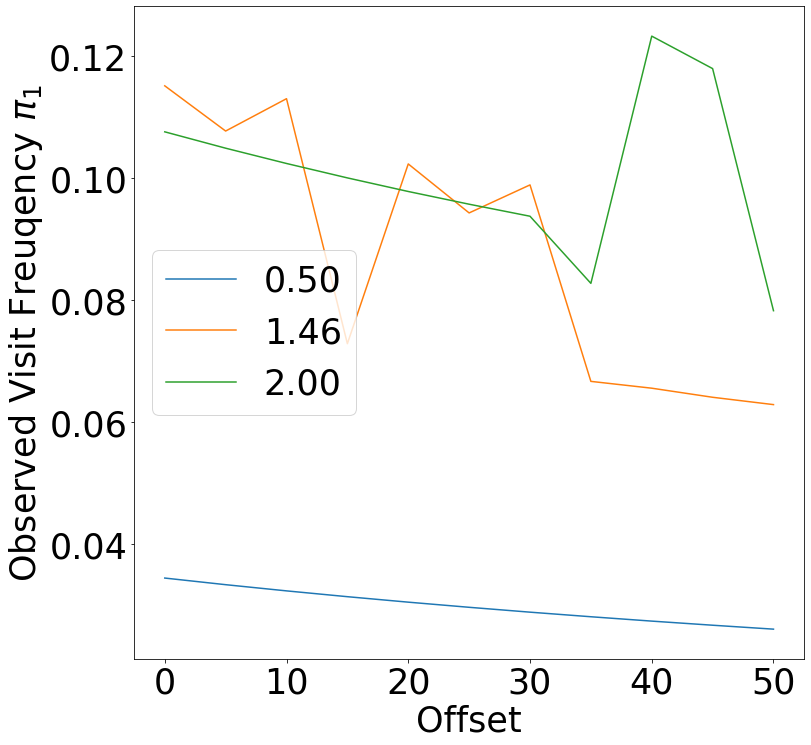

In [89]:
# plt.rcParams.update({
#     "text.usetex": False,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

plt.imshow(pi1s, origin = "lower", extent=[ vals[0], vals[-1], l[0,0], l[-1,0]], aspect = 'auto')
plt.show()

fig = plt.figure(figsize =(12,12))
for i in [0, 5, 10]:
    plt.plot(scale, pi1s[i,:], label="%d m offset"%(l[i]))


plt.ylabel("Observed Visit Freuqency $\\pi_1$")
plt.xlabel("Rate")
plt.legend()
plt.show()

fig = plt.figure(figsize =(12,12))
for j in [0, 9, -1]:
    plt.plot(l, pi1s[:,j], label="%.2f"%(scale[j]))
    
plt.ylabel("Observed Visit Freuqency $\\pi_1$")
plt.xlabel("Offset")
plt.legend()
plt.show()


In [34]:
print(vals*beta)
print(l.T)

[0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115 0.12
 0.125 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175 0.18
 0.185 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235 0.24
 0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295 0.3
 0.305 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355 0.36
 0.365 0.37  0.375 0.38  0.385 0.39  0.395 0.4   0.405 0.41  0.415 0.42
 0.425 0.43  0.435 0.44  0.445 0.45  0.455 0.46  0.465 0.47  0.475 0.48
 0.485 0.49  0.495 0.5  ]
[[ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50.]]


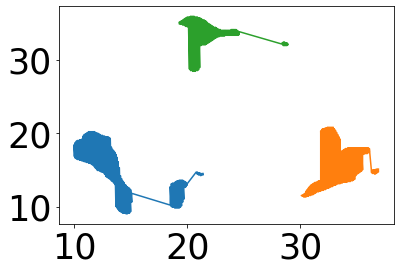

In [18]:
for Xi in dt_sys.Xis:
    pts = Xi['points']
    plt.plot(pts[:,0], pts[:,1])

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
11 total subregions
Extracted edges...
No Improvement, orphaned edges exist
PolyConstructor: ([33.4 11.3])  ([33.1 11.5]) 
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
10 total subregions
Optimized Waiting Time: 25.6347
Optimized Waiting Time: 25.1882
Optimized Waiting Time: 25.1882
Optimized Waiting Time: 31.1914
Optimized Waiting Time: 28.9453
Optimized Waiting Time: 28.9453
Optimized Waiting Time: 32.5216
Optimized Waiting Time: 30.0305
Optimized Waiting Time: 30.0281
Optimized Waiting Time: 33.5503


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 30.2964
Optimized Waiting Time: 30.2892
Optimized Waiting Time: 32.7873
Optimized Waiting Time: 30.2492
Optimized Waiting Time: 30.2467


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 34.1314


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 30.0617
Optimized Waiting Time: 30.0610
Optimized Waiting Time: 32.6443
Optimized Waiting Time: 29.8298
Optimized Waiting Time: 29.8298
Optimized Waiting Time: 31.1848


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 29.5924


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 29.5924


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 33.3182
Optimized Waiting Time: 29.3675
Optimized Waiting Time: 29.3668


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 31.5916


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 29.1619


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 29.1619
Optimized Waiting Time: 30.3892


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.9820


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.9820
Optimized Waiting Time: 31.7953
Optimized Waiting Time: 28.8291
Optimized Waiting Time: 28.8291
Optimized Waiting Time: 31.1277
Optimized Waiting Time: 28.7041
Optimized Waiting Time: 28.7041
Optimized Waiting Time: 32.9809
Optimized Waiting Time: 28.6077
Optimized Waiting Time: 28.6070
Optimized Waiting Time: 30.4066
Optimized Waiting Time: 28.5376
Optimized Waiting Time: 28.5376
Optimized Waiting Time: 30.6634


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.4955


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.4955
Optimized Waiting Time: 32.0078


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.4807


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.4807
Optimized Waiting Time: 31.9636


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.4930


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.4930
Optimized Waiting Time: 30.4268


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.5323
Optimized Waiting Time: 28.5323


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 30.9935


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.5989


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.5989
Optimized Waiting Time: 31.0276
Optimized Waiting Time: 28.6932


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.6932
Optimized Waiting Time: 31.5686
Optimized Waiting Time: 28.8159


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.8159
Optimized Waiting Time: 31.2390


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 28.9679
Optimized Waiting Time: 28.9679


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 31.9567
Optimized Waiting Time: 29.1504
Optimized Waiting Time: 29.1504
Optimized Waiting Time: 32.1662
Optimized Waiting Time: 29.3649
Optimized Waiting Time: 29.3649


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimized Waiting Time: 30.3812
Optimized Waiting Time: 29.6134
Optimized Waiting Time: 29.6134
Optimized Waiting Time: 31.6954
Optimized Waiting Time: 29.8981
Optimized Waiting Time: 29.8981
Optimized Waiting Time: 32.7782
Optimized Waiting Time: 30.2219
Optimized Waiting Time: 30.2219
Optimized Waiting Time: 34.0603
Optimized Waiting Time: 30.5881
Optimized Waiting Time: 30.5881
Optimized Waiting Time: 34.2951
Optimized Waiting Time: 31.0008
Optimized Waiting Time: 31.0008


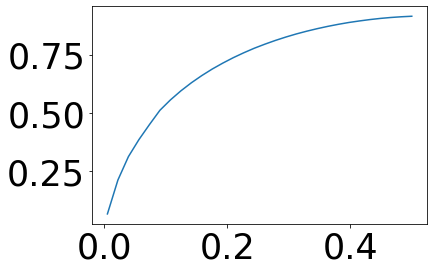

In [14]:
#plot vs rate
import cplex_solvers as CPLX

reload(CPLX)
reload(PS)
reload(dtr)
reload(sim)
#reload(MRP)
v = 1

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

els = np.array([0.05, 0.05, 0.05])/beta
n_steps = 30
vals = np.linspace(0.005, 0.5, n_steps)/beta

dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps = dt_sys.ps
pi1s = []
first = True
for val in vals:
    els[0] = val
    ps.Ls = els
    AORP = sim.calc_AORP(dt_sys, v)
    pi = AORP['pi']
    #S = dtr.XtoS(AORP['X'])
    pi1s.append(pi[0])
    if not first:
        if pi1s[-2]>pi1s[-1]:
            print(pi)
    first = False

plt.plot(vals*beta, pi1s)

In [84]:
vals*beta
print(pi1s)
print(region)
print(scale)

[[0.05914123 0.06802172 0.07637751 0.0842277  0.09161169 0.09855017
  0.10510481 0.11135534 0.16794767 0.17082255 0.17683357 0.14681548
  0.15173271 0.15642283 0.16088684]
 [0.05735305 0.06605783 0.07426511 0.08199649 0.08927762 0.09613909
  0.10260777 0.10873374 0.11498457 0.1748213  0.17686462 0.14372399
  0.14861793 0.15325061 0.1576895 ]
 [0.05567178 0.06421106 0.07227765 0.07988405 0.08707482 0.09385543
  0.10024553 0.15273315 0.15547327 0.15921794 0.17554995 0.17620638
  0.14563586 0.15025202 0.15465632]
 [0.05409045 0.20090167 0.07040063 0.07790439 0.08499236 0.09168523
  0.09800914 0.10399147 0.15591951 0.15109656 0.17343278 0.17685469
  0.14283273 0.1474072  0.15177848]
 [0.05260186 0.06082634 0.06863146 0.07602789 0.08301829 0.08963734
  0.09588686 0.10180484 0.10741679 0.11281409 0.15402669 0.17496785
  0.1795788  0.14470885 0.14904521]
 [0.05119473 0.05927096 0.06695007 0.0742425  0.08114628 0.08768189
  0.09386967 0.0997298  0.15356845 0.16118301 0.15145232 0.16564558
  0.

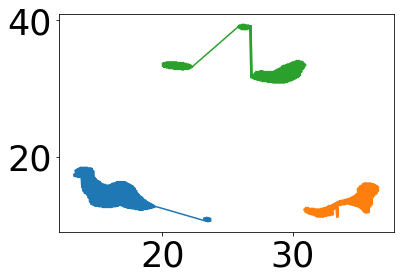

In [16]:
for Xi in dt_sys.Xis:
    pts = Xi['points']
    plt.plot(pts[:,0], pts[:,1])

In [ ]:
import CoordTransforms as CT
    

def brute_force(dt_sys):
    argmin = None
    w_min = float('inf')
    ps = dt_sys.ps
    all_points = dt_sys.Xis
    r0_pts = CT.change_res(all_points[0]['points'], pcs[0].region, 2)
    r1_pts = CT.change_res(all_points[1]['points'], pcs[2].region, 2)
    r2_pts = CT.change_res(all_points[2]['points'], pcs[4].region, 2)
    print("Total iterations: %d"%(400*len(r0_pts)*len(r1_pts)*len(r2_pts)))
    count = 0
    for pt0 in r0_pts:
        for pt1 in r1_pts:
            for pt2 in r2_pts:
                X = np.array([pt0, pt1, pt2])
                S = dtr.XtoS(X)
                for pi_0 in np.arange(0.05,1, 0.05):
                    for pi_1 in np.arange(0.05,1-pi_0, 0.05):
                            pi_2 = 1 - pi_0 - pi_1
                            pi = np.array([pi_0, pi_1, pi_2])
                            w = ps._calc_avg_wait_random(pi, S)
                            if w < w_min:
                                argmin = (pi, X)
                                w_min = w
                            count += 1
                            if count %50000 == 0:
                                print(count)
    return w_min, argmin

In [ ]:
brute_force(dt_sys)

In [ ]:
if False:
    %store dt_sys AORP TSPNP tjcps pjcps qBase region pcs pfs pjcps prob_pred_con ccs cfs true_joint_con_fields tjcps

In [28]:
rhos = els*beta
pi = np.sqrt(rhos*(1-rhos))/sum(np.sqrt(rhos*(1-rhos)))
print(pi)

[0.53425088 0.23287456 0.23287456]
